In [148]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Load preprocessed data
train_file = 'preprocessed_train.csv'
test_file = 'preprocessed_test.csv'

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Define columns for image features, target column, and other features
img_feature_cols = [str(i) for i in range(12278, 12288)]  # 10 个图片嵌入特征列
target_column = 'Lunch Calories'  # 目标列
other_feature_cols = [col for col in train_data.columns if col not in img_feature_cols + [target_column]]

# Ensure test data has all columns present in train data
missing_cols = [col for col in other_feature_cols if col not in test_data.columns]
for col in missing_cols:
    print(f"Adding missing column '{col}' to test data with default value 0.")
    test_data[col] = 0  # Fill missing columns with 0

# Align test data column order with train data
test_data = test_data[img_feature_cols + other_feature_cols]

# Ensure all columns are numeric
train_data_numeric = train_data[img_feature_cols + other_feature_cols + [target_column]].apply(pd.to_numeric, errors='coerce')
test_data_numeric = test_data[img_feature_cols + other_feature_cols].apply(pd.to_numeric, errors='coerce')

# Handle missing values
train_data_numeric = train_data_numeric.fillna(0)
test_data_numeric = test_data_numeric.fillna(0)

# Extract image features, other features, and labels
img_train = train_data_numeric[img_feature_cols].values.astype(np.float32)  # [N, 10]
other_train = train_data_numeric[other_feature_cols].values.astype(np.float32)
labels_train = train_data_numeric[target_column].values.astype(np.float32)

img_test = test_data_numeric[img_feature_cols].values.astype(np.float32)  # [M, 10]
other_test = test_data_numeric[other_feature_cols].values.astype(np.float32)

# Custom Dataset class for PyTorch
class MultiModalDataset(Dataset):
    def __init__(self, img_features, other_features, labels=None):
        self.img_features = torch.tensor(img_features, dtype=torch.float32)
        self.other_features = torch.tensor(other_features, dtype=torch.float32)
        self.labels = None if labels is None else torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.img_features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.img_features[idx], self.other_features[idx], self.labels[idx]
        return self.img_features[idx], self.other_features[idx]

# Create DataLoader for train and test datasets
train_dataset = MultiModalDataset(img_train, other_train, labels_train)
test_dataset = MultiModalDataset(img_test, other_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data Loaders Created Successfully!")

# Validate DataLoader outputs
print("Validating Train DataLoader:")
for img_batch, other_batch, label_batch in train_loader:
    print("Image Features Shape:", img_batch.shape)  # [batch_size, 10]
    print("Other Features Shape:", other_batch.shape)  # [batch_size, len(other_feature_cols)]
    print("Labels Shape:", label_batch.shape)  # [batch_size]
    break

print("Validating Test DataLoader:")
for img_batch, other_batch in test_loader:
    print("Test Image Features Shape:", img_batch.shape)  # [batch_size, 10]
    print("Test Other Features Shape:", other_batch.shape)  # [batch_size, len(other_feature_cols)]
    break


Adding missing column 'Lunch Carbs' to test data with default value 0.
Adding missing column 'Lunch Fat' to test data with default value 0.
Adding missing column 'Lunch Protein' to test data with default value 0.
Data Loaders Created Successfully!
Validating Train DataLoader:
Image Features Shape: torch.Size([32, 10])
Other Features Shape: torch.Size([32, 12343])
Labels Shape: torch.Size([32])
Validating Test DataLoader:
Test Image Features Shape: torch.Size([32, 10])
Test Other Features Shape: torch.Size([32, 12343])


Epoch 1/500, Train Loss: 0.8913
Epoch 2/500, Train Loss: 0.3908
Epoch 3/500, Train Loss: 0.3954
Epoch 4/500, Train Loss: 0.3810
Epoch 5/500, Train Loss: 0.3967
Epoch 6/500, Train Loss: 0.3396
Epoch 7/500, Train Loss: 0.3525
Epoch 8/500, Train Loss: 0.3481
Epoch 9/500, Train Loss: 0.3342
Epoch 10/500, Train Loss: 0.3508
Epoch 11/500, Train Loss: 0.3932
Epoch 12/500, Train Loss: 0.3491
Epoch 13/500, Train Loss: 0.3889
Epoch 14/500, Train Loss: 0.3179
Epoch 15/500, Train Loss: 0.3303
Epoch 16/500, Train Loss: 0.3226
Epoch 17/500, Train Loss: 0.3186
Epoch 18/500, Train Loss: 0.3263
Epoch 19/500, Train Loss: 0.3257
Epoch 20/500, Train Loss: 0.3835
Epoch 21/500, Train Loss: 0.3619
Epoch 22/500, Train Loss: 0.3295
Epoch 23/500, Train Loss: 0.3375
Epoch 24/500, Train Loss: 0.3438
Epoch 25/500, Train Loss: 0.3139
Epoch 26/500, Train Loss: 0.3149
Epoch 27/500, Train Loss: 0.3110
Epoch 28/500, Train Loss: 0.2936
Epoch 29/500, Train Loss: 0.2987
Epoch 30/500, Train Loss: 0.2988
Epoch 31/500, Train

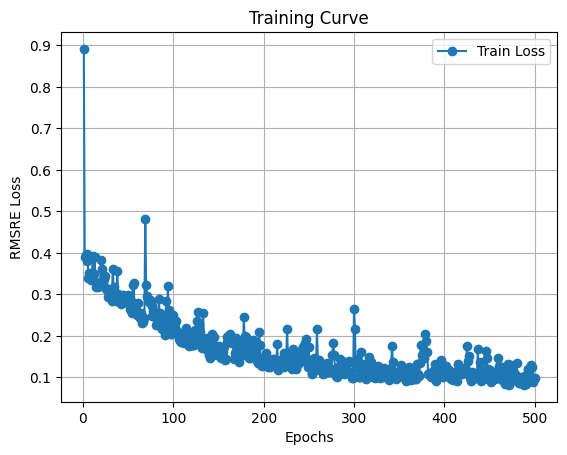

In [154]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


# Dataset Class for MultiModal Data
class MultiModalDataset(Dataset):
    def __init__(self, img_data, other_feats, labels=None):
        """
        Dataset for multi-modal inputs.
        Args:
            img_data (numpy.ndarray): Image data of shape [N, D_img].
            other_feats (numpy.ndarray): Other modality features of shape [N, D_other].
            labels (numpy.ndarray or None): Labels of shape [N].
        """
        self.img_data = torch.tensor(img_data, dtype=torch.float32)
        self.other_feats = torch.tensor(other_feats, dtype=torch.float32)
        self.labels = None if labels is None else torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.img_data[idx], self.other_feats[idx], self.labels[idx]
        return self.img_data[idx], self.other_feats[idx]


# MultiModal Model
class MultiModalModel(nn.Module):
    def __init__(self, img_embed_dim, other_feat_dim, hidden_dim, output_dim):
        super().__init__()
        # Fully connected layers for image features
        self.fc_img = nn.Sequential(
            nn.Linear(img_embed_dim, hidden_dim),
            nn.ReLU(),
        )
        # Fully connected layers for other features
        self.fc_other = nn.Sequential(
            nn.Linear(other_feat_dim, hidden_dim),
            nn.ReLU(),
        )
        # Final prediction layer
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, img_feats, other_feats):
        img_embed = self.fc_img(img_feats)
        other_embed = self.fc_other(other_feats)
        combined = torch.cat([img_embed, other_embed], dim=1)
        output = self.fc_out(combined)
        return output


# RMSRE Loss Function
def rmsre(y_pred, y_true):
    epsilon = 1e-8
    loss = torch.sqrt(torch.mean(((y_true - y_pred) / (y_true + epsilon)) ** 2))
    return loss


# DataLoaders
train_dataset = MultiModalDataset(img_train, other_train, labels_train)
test_dataset = MultiModalDataset(img_test, other_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Training
img_embed_dim = img_train.shape[1]
other_feat_dim = other_train.shape[1]
hidden_dim = 128
output_dim = 1
learning_rate = 0.001
num_epochs = 500

model = MultiModalModel(img_embed_dim, other_feat_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for img_batch, other_batch, labels in train_loader:
        optimizer.zero_grad()
        predictions = model(img_batch, other_batch).squeeze()
        labels = torch.clamp(labels, min=1e-8)
        loss = rmsre(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}")



# Plot Training Curve
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("RMSRE Loss")
plt.title("Training Curve")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader

# 超参数选项
hidden_dim_options = [64, 128, 256]
learning_rate_options = [0.001, 0.0005]
batch_size_options = [32, 64]

best_val_loss = float('inf')
best_model = None
best_hyperparams = None

# 超参数调优
for hidden_dim in hidden_dim_options:
    for learning_rate in learning_rate_options:
        for batch_size in batch_size_options:
            print(f"\nTraining with hidden_dim={hidden_dim}, lr={learning_rate}, batch_size={batch_size}")

            # DataLoader with current batch_size
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Model setup
            model = MultiModalModel(img_embed_dim, other_feat_dim, hidden_dim, output_dim)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            criterion = rmsre  # RMSRE as the loss function

            num_epochs = 500
            train_losses = []
            val_losses = []
            patience = 20  # Early stopping patience
            best_epoch_val_loss = float('inf')
            epochs_without_improvement = 0

            # Training loop
            for epoch in range(num_epochs):
                model.train()
                epoch_train_loss = 0
                for img_batch, other_batch, labels in train_loader:
                    optimizer.zero_grad()
                    predictions = model(img_batch, other_batch).squeeze()
                    labels = torch.clamp(labels, min=1e-8)
                    loss = criterion(predictions, labels)
                    loss.backward()
                    optimizer.step()
                    epoch_train_loss += loss.item()
                train_losses.append(epoch_train_loss / len(train_loader))

                # Validation loop
                model.eval()
                with torch.no_grad():
                    if hasattr(test_dataset, 'labels') and test_dataset.labels is not None:
                        epoch_val_loss = 0
                        for img_batch, other_batch, labels in test_loader:
                            predictions = model(img_batch, other_batch).squeeze()
                            labels = torch.clamp(labels, min=1e-8)
                            loss = rmsre(predictions, labels)
                            epoch_val_loss += loss.item()
                        val_losses.append(epoch_val_loss / len(test_loader))
                        print(f"Validation Loss: {val_losses[-1]:.4f}")

                # 打印日志
                if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
                    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")

                if epochs_without_improvement >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

                # 保存最佳模型
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model.state_dict()  # Save model state
                    best_hyperparams = (hidden_dim, learning_rate, batch_size)

# 保存最佳模型及超参数
torch.save({'model_state_dict': best_model, 'hyperparams': best_hyperparams}, "best_model.pth")
print(f"Best model saved with Validation Loss: {best_val_loss:.4f}")
print(f"Best Hyperparameters: hidden_dim={best_hyperparams[0]}, lr={best_hyperparams[1]}, batch_size={best_hyperparams[2]}")

# 加载最佳模型
checkpoint = torch.load("best_model.pth")
best_model = MultiModalModel(img_embed_dim, other_feat_dim, checkpoint['hyperparams'][0], output_dim)
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model.eval()

# 推理并生成 Kaggle 提交文件
predictions = []
with torch.no_grad():
    for img_batch, other_batch in test_loader:
        preds = best_model(img_batch, other_batch).squeeze()
        predictions.extend(preds.cpu().numpy())

# 生成提交文件
submission = pd.DataFrame({"row_id": np.arange(len(predictions)), "label": predictions})
submission.to_csv("submission.csv", index=False)
print("Predictions saved to 'submission.csv' in Kaggle format.")



Training with hidden_dim=64, lr=0.001, batch_size=32


In [153]:
# Prediction
predictions = []
with torch.no_grad():
    for img_batch, other_batch in test_loader:
        preds = model(img_batch, other_batch).squeeze()
        predictions.extend(preds.cpu().numpy())

# Prepare Kaggle submission file
test_ids = np.arange(len(predictions))  # row_id 从 0 开始，按顺序生成
submission = pd.DataFrame({"row_id": test_ids, "label": predictions})
submission.to_csv("submission.csv", index=False)
print("Predictions saved to 'submission.csv' in Kaggle format.")


Predictions saved to 'submission.csv' in Kaggle format.
